# Time series  forecasting  using LSTM model

* Time-series is sequnetial in nature and it is always in order

# Libraries and Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM , Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM , Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
from tensorflow.keras.metrics import MeanAbsoluteError as MAE_Metric
from tensorflow.keras.metrics import MeanSquaredError as MSE_Metric
from tensorflow.keras.metrics import RootMeanSquaredError

# 1. Load Data set

In [2]:
datafile_1 = pd.read_csv("AAPL.csv")
datafile_1.head()
datafile = datafile_1.iloc[9847:,:]

In [3]:
datafile[datafile["Date"] == "2020-01-02"]

,Date,Open,High,Low,Close,Adj Close,Volume
9847,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.785912,135480400


In [4]:
datafile.head()

,Date,Open,High,Low,Close,Adj Close,Volume
9847,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.785912,135480400
9848,2020-01-03,74.287498,75.144997,74.125000,74.357498,73.068565,146322800
9849,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.650795,118387200
9850,2020-01-07,74.959999,75.224998,74.370003,74.597504,73.304413,108872000
9851,2020-01-08,74.290001,76.110001,74.290001,75.797501,74.483620,132079200


# 2. Pre-proccessing data

## 2.1) Missing values checking

In [5]:
datafile.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

* We can see that there are `no missing values` in this data set

# 2.2) Information of data set

In [6]:
datafile.shape

(621, 7)

* There are `3137 records` and `7 column` in this data set

In [7]:
datafile.size

4347

In [8]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 9847 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       621 non-null    object 
 1   Open       621 non-null    float64
 2   High       621 non-null    float64
 3   Low        621 non-null    float64
 4   Close      621 non-null    float64
 5   Adj Close  621 non-null    float64
 6   Volume     621 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 34.1+ KB


## 2.3) Changing data type of Date column

In [9]:
datafile["Date"] = pd.to_datetime(datafile["Date"])

C:\Users\Induwara Dilshan\AppData\Local\Temp\ipykernel_3220\19306091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile["Date"] = pd.to_datetime(datafile["Date"])


In [10]:
datafile.index.dtype

dtype('int64')

In [11]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 9847 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       621 non-null    datetime64[ns]
 1   Open       621 non-null    float64       
 2   High       621 non-null    float64       
 3   Low        621 non-null    float64       
 4   Close      621 non-null    float64       
 5   Adj Close  621 non-null    float64       
 6   Volume     621 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 34.1 KB


## 2.4) Changing index to Date column

In [12]:
datafile.set_index("Date",inplace=True)

In [13]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 621 entries, 2020-01-02 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       621 non-null    float64
 1   High       621 non-null    float64
 2   Low        621 non-null    float64
 3   Close      621 non-null    float64
 4   Adj Close  621 non-null    float64
 5   Volume     621 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 34.0 KB


## 2.5) Sort the index column in dataset

In [14]:
datafile.sort_index(inplace=True)

In [15]:
datafile.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.785912,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.068565,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.650795,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.304413,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.483620,132079200


# 2.6) Normalization 

In [16]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(datafile[datafile.columns])

* Why did I use MinMaxScaler() method ?
    * Preserves temporal relationships : shape and trends of your time series remain intact
    * Bounded output range : range helps with training stability and convergence to overcome the exploding grediant descent.
    * Handles non-stationary data well (Best)
    * 
* Why didn't I use StandardScaler ?
    * data is normally distributed, which time series often aren't
    * Outliers can significantly skew the mean and standard deviation
    * The unbounded output range can cause training instability in neural networks

In [17]:
scaler_data

array([[0.13565797, 0.14326592, 0.16389149, 0.15085277, 0.14679877,
        0.24507899],
       [0.13746913, 0.14322614, 0.16649136, 0.14505529, 0.14111729,
        0.27320381],
       [0.1307818 , 0.14199418, 0.15904897, 0.14976074, 0.14572862,
        0.2007398 ],
       ...,
       [0.61515795, 0.63756305, 0.62720549, 0.63007522, 0.63502731,
        0.13108091],
       [0.59756388, 0.59821959, 0.6024371 , 0.58742829, 0.5924963 ,
        0.17411714],
       [0.58156201, 0.60370386, 0.60854983, 0.59934085, 0.60437648,
        0.24154626]])

## 2.7) Scaler data to pandas DataFrame

In [18]:
scaler_df = pd.DataFrame(scaler_data, columns=datafile.columns , index= datafile.index)

In [19]:
scaler_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,0.135658,0.143266,0.163891,0.150853,0.146799,0.245079
2020-01-03,0.137469,0.143226,0.166491,0.145055,0.141117,0.273204
2020-01-06,0.130782,0.141994,0.159049,0.149761,0.145729,0.200740
2020-01-07,0.142823,0.143862,0.168436,0.146961,0.142985,0.176058
2020-01-08,0.137489,0.150896,0.167801,0.156491,0.152325,0.236256


# 3) Plotting the column

* using ploting data, we can analysis whether, there is a seasonal trend or stationary or upward trend/downward trend or pattern in dataset

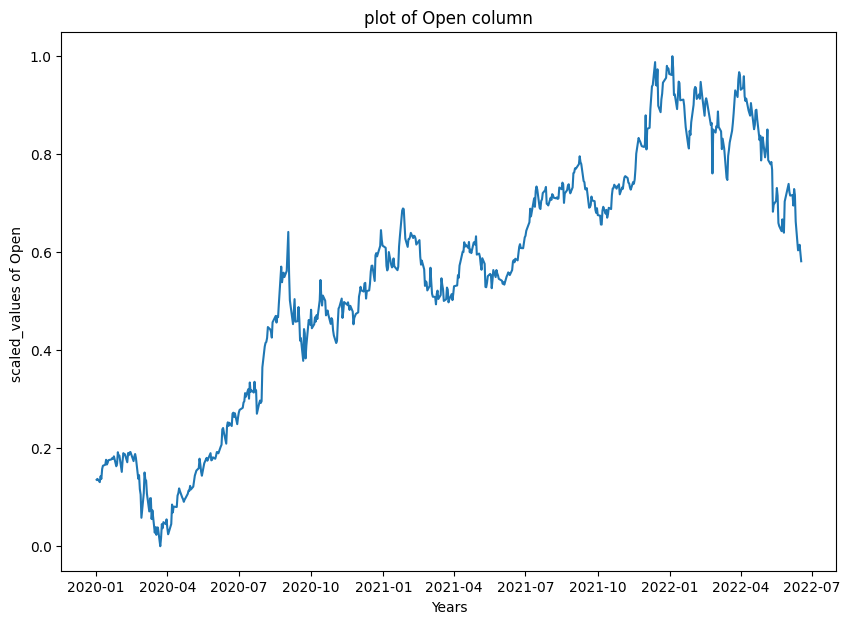

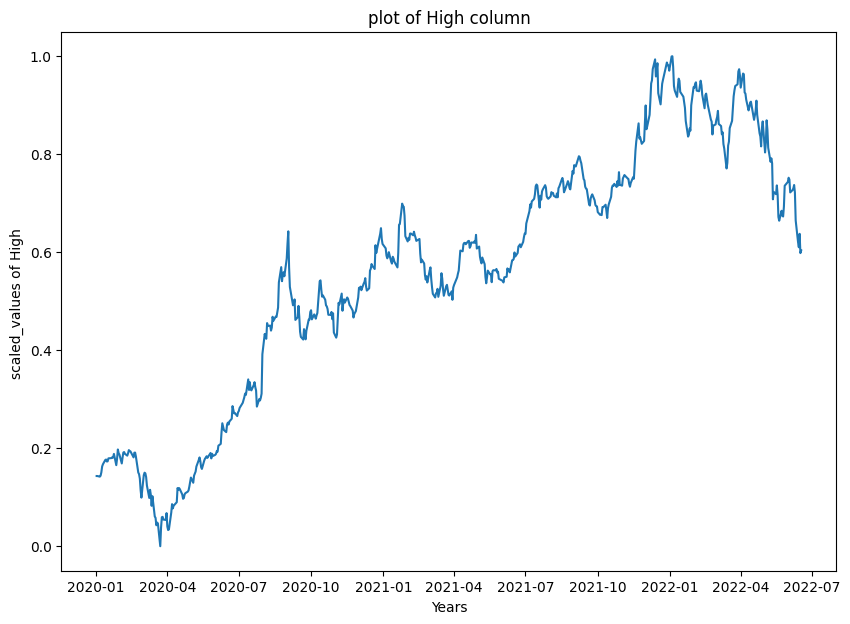

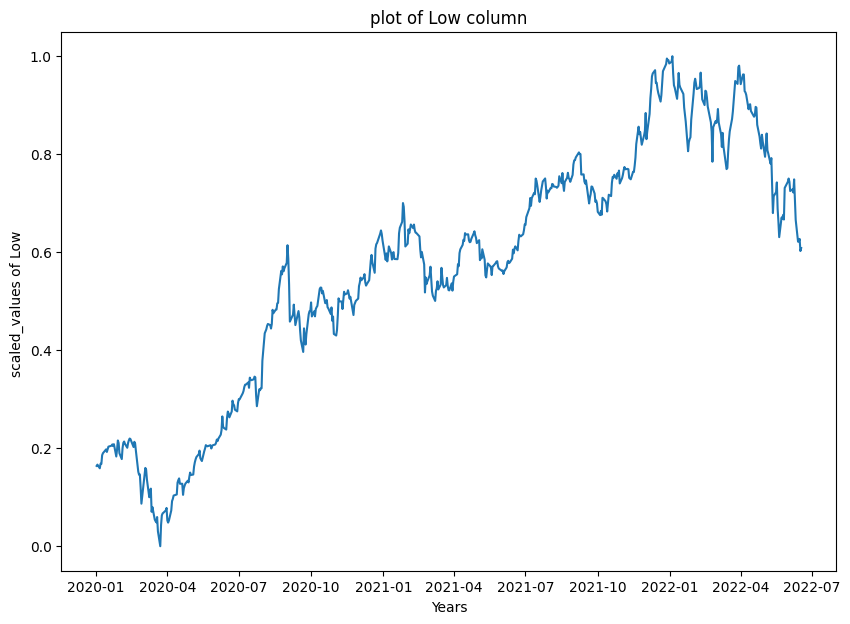

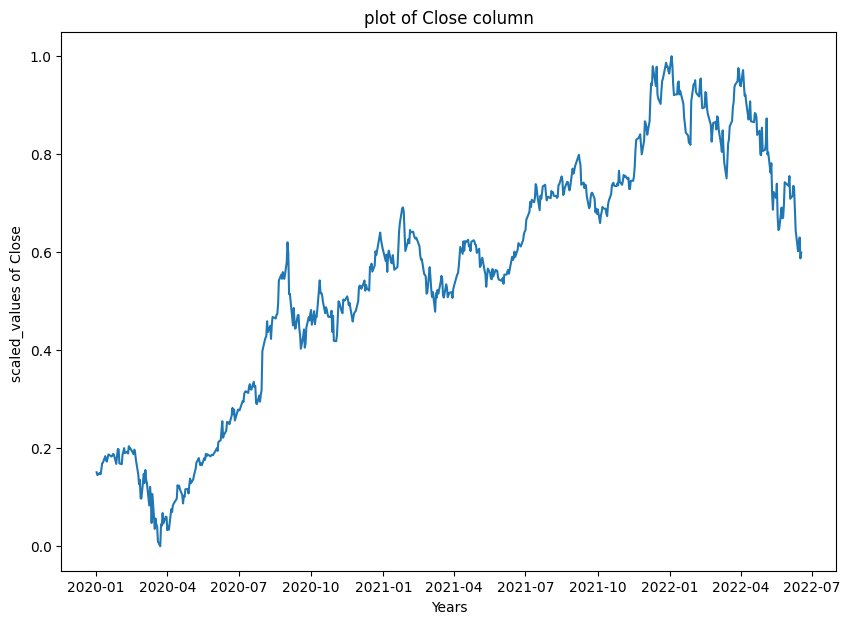

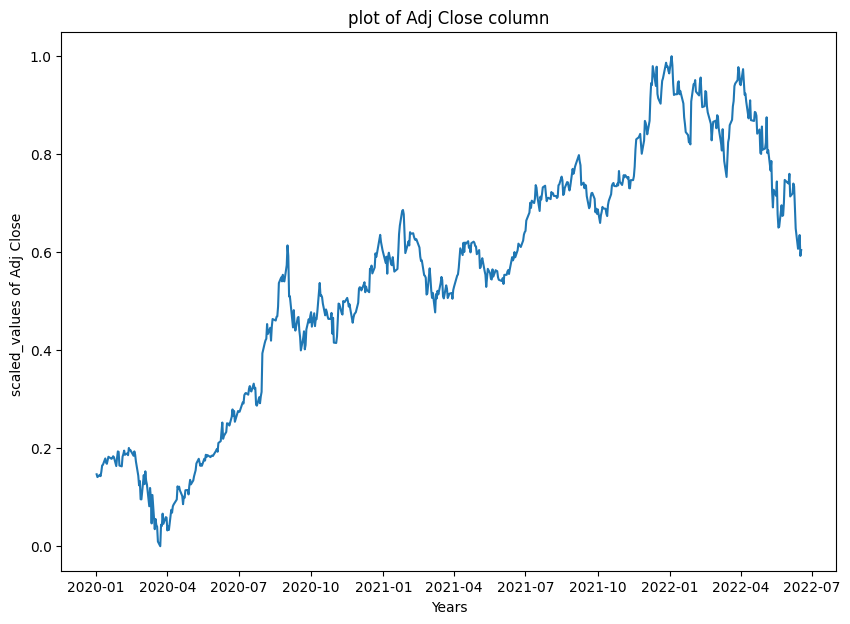

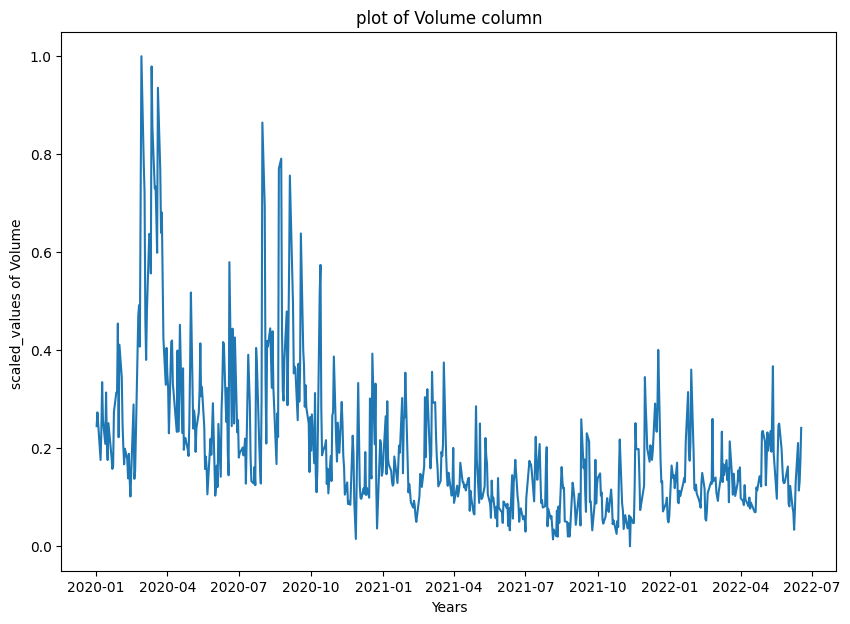

In [20]:
col_names =scaler_df.columns

for i in col_names:
    plt.figure(figsize=(10,7))
    plt.plot(scaler_df[i])
    plt.title(f"plot of {i} column")
    plt.ylabel(f"scaled_values of {i} ")
    plt.xlabel("Years")
    plt.show()


In [21]:
scaler_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

### Some interpretation of above plot

* Varibles for  `'Open', 'High', 'Low', 'Close', 'Adj Close' have approximately same plots`.
* but, final plot for `variable  'Volume' is different from other all variable`.

# 4) Sliding Window Sequence 

### what is the `Sliding Window Sequence` ?

* Sliding Window Sequence is a  technique where the time series data is segmented into overlapping fixed-length sequences (windows) to create input-output pairs for supervised learning.
* It involves some window which is  Fixed size of consecutive past observation. These observation are taken as input feature.using these input, it predicts next output.

Ex:
* window size = 4
* Let's take time states : 1,2,3,4...10

    *   [1,2,3,4] ==> [5]
    *   [2,3,4,5] ==> [6]
    *   [3,4,5,6] ==> [7]
    *   [4,5,6,7] ==> [8]

* from this method, we can convert original time series data into supervised learning problem suitable for models like LSTM.




In [22]:
def create_sequence(dataframe , window_size):
    x = []
    y = []

    for i in range(window_size, len(dataframe)):
        x.append(dataframe.iloc[i-window_size:i].values)
        y.append(dataframe.iloc[i].values)
    return np.array(x) , np.array(y)

    

In [23]:
window_size = 60
x ,y = create_sequence(scaler_df, window_size)

In [24]:
x.shape , y.shape

((561, 60, 6), (561, 6))

* Interpretation : in x array, there are single list of 500 sequences.

In [25]:
x

array([[[0.13565797, 0.14326592, 0.16389149, 0.15085277, 0.14679877,
         0.24507899],
        [0.13746913, 0.14322614, 0.16649136, 0.14505529, 0.14111729,
         0.27320381],
        [0.1307818 , 0.14199418, 0.15904897, 0.14976074, 0.14572862,
         0.2007398 ],
        ...,
        [0.04511981, 0.05911457, 0.06289322, 0.0419918 , 0.04124937,
         0.68118077],
        [0.03670091, 0.05996899, 0.06698157, 0.06764351, 0.06644757,
         0.54755311],
        [0.04910039, 0.0543854 , 0.06835097, 0.04639945, 0.04557915,
         0.4233789 ]],

       [[0.13746913, 0.14322614, 0.16649136, 0.14505529, 0.14111729,
         0.27320381],
        [0.1307818 , 0.14199418, 0.15904897, 0.14976074, 0.14572862,
         0.2007398 ],
        [0.14282301, 0.143862  , 0.16843633, 0.14696135, 0.14298524,
         0.17605769],
        ...,
        [0.03670091, 0.05996899, 0.06698157, 0.06764351, 0.06644757,
         0.54755311],
        [0.04910039, 0.0543854 , 0.06835097, 0.04639945, 0.045

In [26]:
y

array([[0.04509992, 0.05368995, 0.07301485, 0.0604364 , 0.05936791,
        0.32937252],
       [0.05477272, 0.06753962, 0.07817493, 0.05940397, 0.05835369,
        0.40466395],
       [0.03666109, 0.04017804, 0.05263263, 0.03283898, 0.03225842,
        0.35075199],
       ...,
       [0.61515795, 0.63756305, 0.62720549, 0.63007522, 0.63502731,
        0.13108091],
       [0.59756388, 0.59821959, 0.6024371 , 0.58742829, 0.5924963 ,
        0.17411714],
       [0.58156201, 0.60370386, 0.60854983, 0.59934085, 0.60437648,
        0.24154626]])

# 5. Train test data splitting

In [27]:
x_train, x_test , y_train , y_test = train_test_split(x,y, random_state = 42)

In [28]:
x_train.shape , x_test.shape

((420, 60, 6), (141, 60, 6))

# 6. Building LSTM model

In [29]:
# Building model
model = Sequential()

model.add(LSTM(128, return_sequences=True ,input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(128 , return_sequences=True ))
model.add(Dropout(0.3))
model.add(LSTM(64 , return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(6))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanAbsoluteError(),
    metrics=[MAE_Metric(), MSE_Metric()]
)

c:\Users\Induwara Dilshan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# Early stopping 
callback = EarlyStopping(monitor = "val_loss" , 
                         patience = 5 , 
                         restore_best_weights = True)

# fit the model

In [31]:

history_1 = model.fit(x_train,y_train,validation_split=0.2 ,epochs=50 , batch_size=5 , callbacks=callback )

Epoch 1/50


68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 0.2095 - mean_absolute_error: 0.2095 - mean_squared_error: 0.0856 - val_loss: 0.0649 - val_mean_absolute_error: 0.0649 - val_mean_squared_error: 0.0071
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1181 - mean_absolute_error: 0.1181 - mean_squared_error: 0.0250 - val_loss: 0.0619 - val_mean_absolute_error: 0.0619 - val_mean_squared_error: 0.0073
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.1030 - mean_absolute_error: 0.1030 - mean_squared_error: 0.0179 - val_loss: 0.0850 - val_mean_absolute_error: 0.0850 - val_mean_squared_error: 0.0105
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0978 - mean_absolute_error: 0.0978 - mean_squared_error: 0.0168 - val_loss: 0.1239 - val_mean_absolute_error: 0.1239 - val_mean_squared_error: 0.0206
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0963 - mean_absolute_error: 0.0963 - mean_squared_error: 0.0155 - val_loss: 0.0589 - val_mean_absolute_er

# predict the data

In [32]:
prediction = model.predict(x_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


# Evaluation model

In [33]:
test_loss, test_mae, test_mse = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - mean_squared_error: 0.0045
Test Loss: 0.03759288787841797
Test MAE: 0.03759288787841797


# Forecasting data

In [34]:
predictions = scaler.inverse_transform(prediction)
y_test_rescaler = scaler.inverse_transform(y_test)

# Plotting `Actual Vs Predicted`

In [35]:
y_test_rescaler

array([[1.68710007e+02, 1.69029999e+02, 1.65500000e+02, 1.65750000e+02,
        1.65506821e+02, 7.22467000e+07],
       [1.46350006e+02, 1.47110001e+02, 1.45630005e+02, 1.46139999e+02,
        1.45527527e+02, 5.41268000e+07],
       [1.24529999e+02, 1.25949997e+02, 1.21000000e+02, 1.21779999e+02,
        1.20702492e+02, 1.15089200e+08],
       [1.02885002e+02, 1.06415001e+02, 1.00824997e+02, 1.06260002e+02,
        1.04949211e+02, 3.74336800e+08],
       [1.48270004e+02, 1.49830002e+02, 1.47699997e+02, 1.48990005e+02,
        1.48143631e+02, 7.24341000e+07],
       [1.21279999e+02, 1.21550003e+02, 1.18809998e+02, 1.19019997e+02,
        1.17763748e+02, 1.15393800e+08],
       [1.41580002e+02, 1.44059998e+02, 1.40669998e+02, 1.43240005e+02,
        1.42426285e+02, 1.05575500e+08],
       [1.56009995e+02, 1.59440002e+02, 1.54179993e+02, 1.57279999e+02,
        1.57279999e+02, 1.16124600e+08],
       [1.19262497e+02, 1.24867500e+02, 1.19250000e+02, 1.24370003e+02,
        1.23057281e+02, 

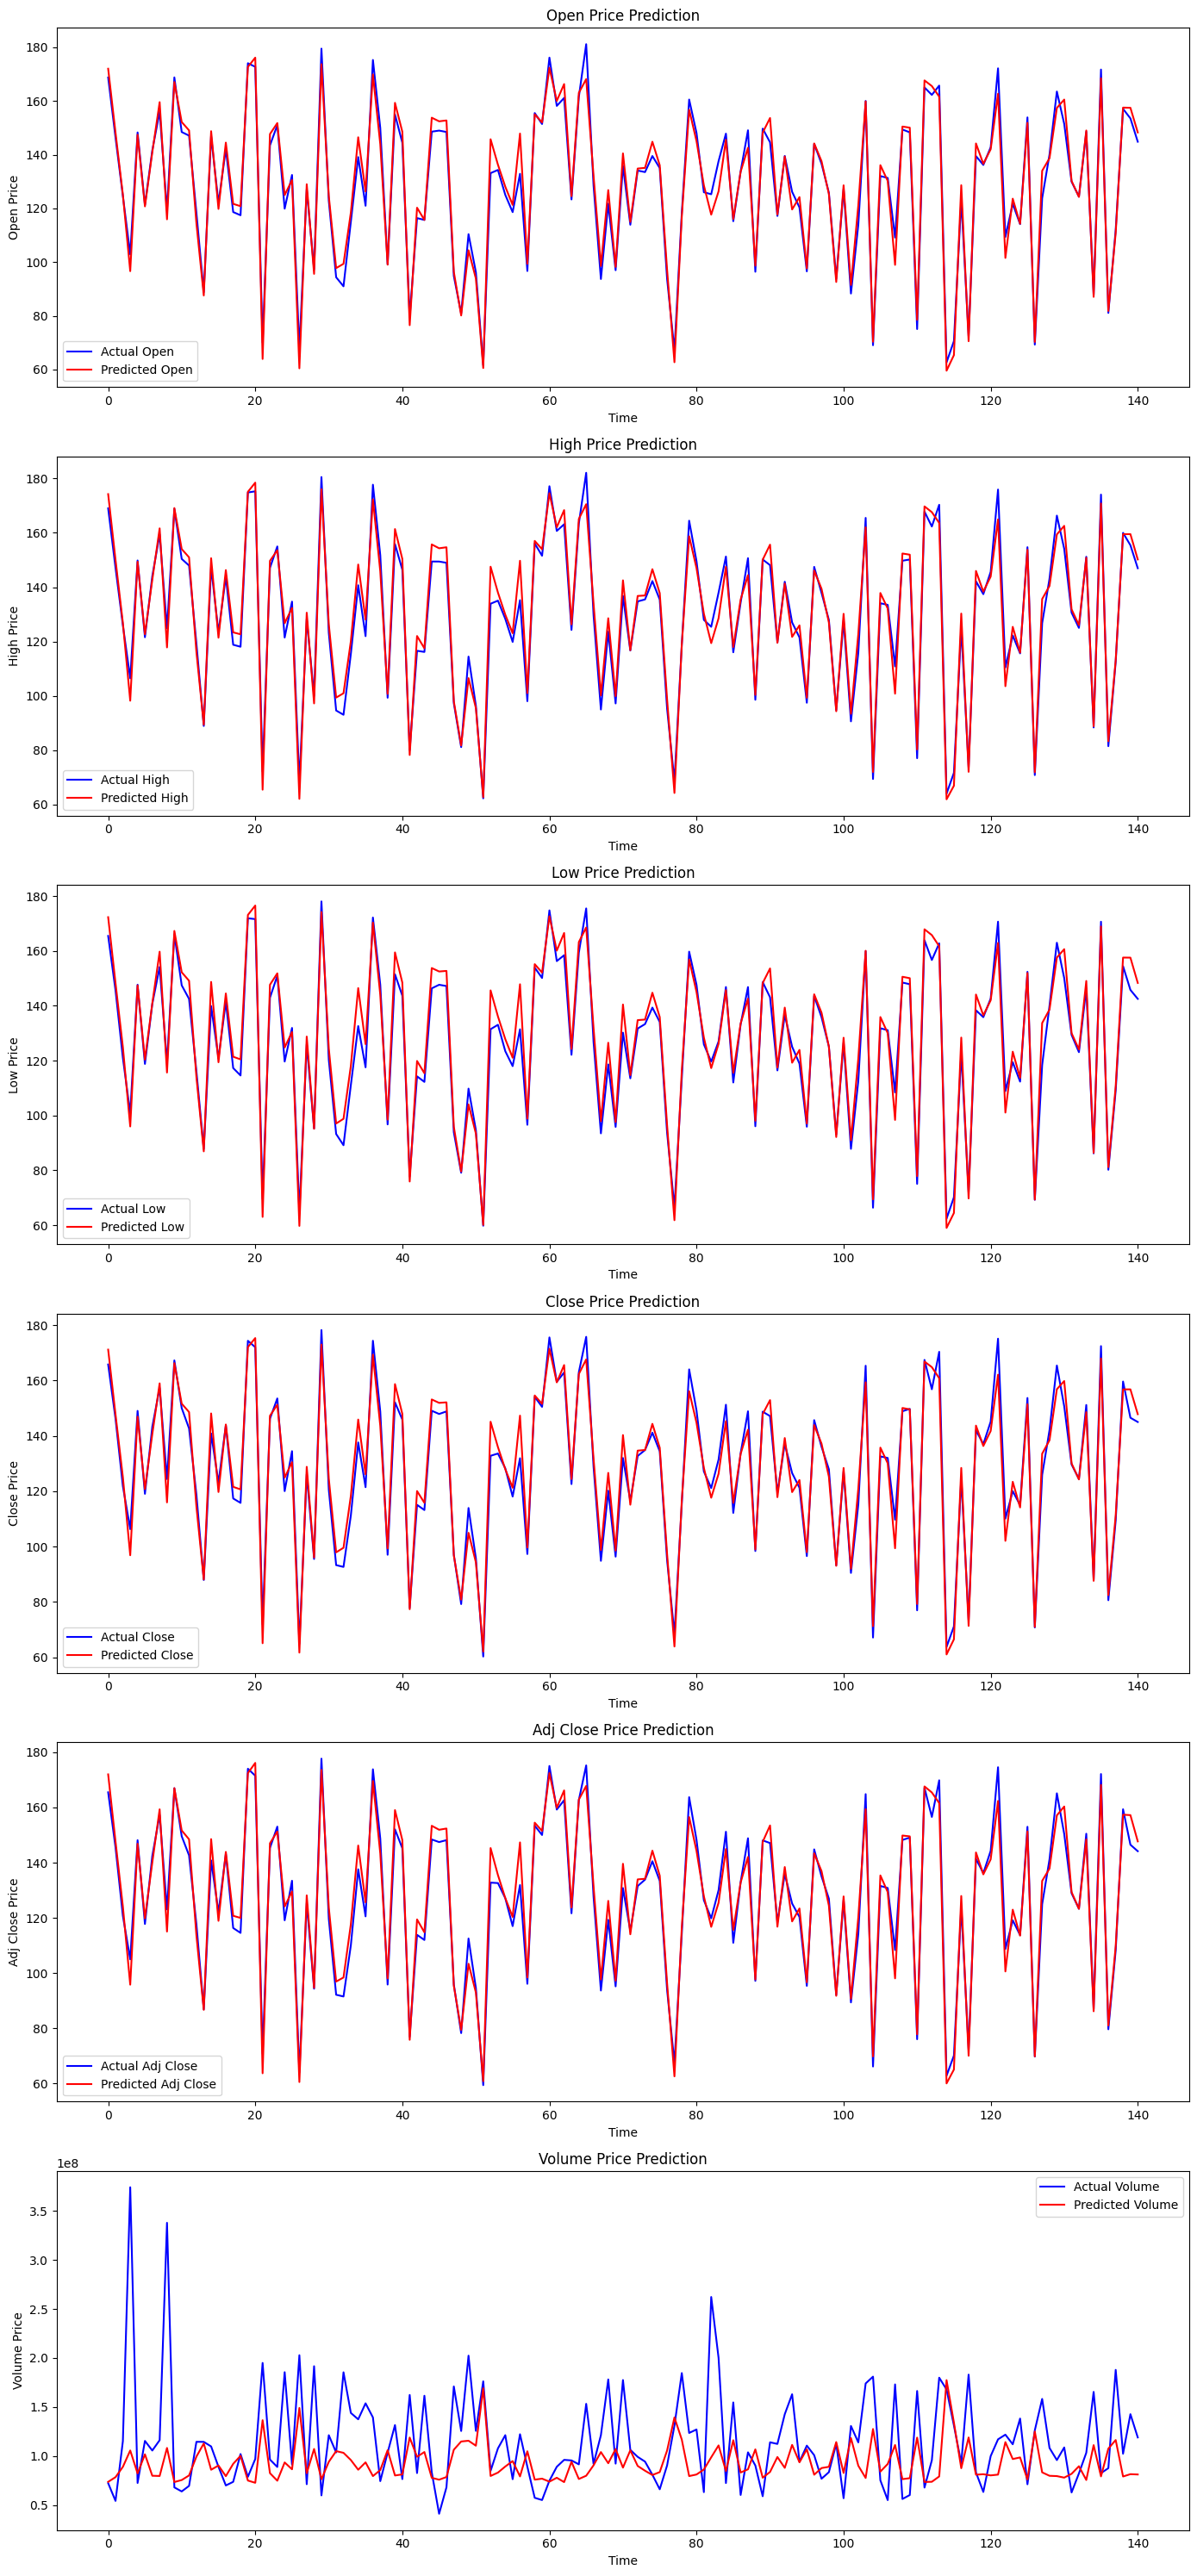

In [36]:
plt.figure(figsize=(14, 30))

for i, col in enumerate(scaler_df.columns):
    plt.subplot(6, 1, i + 1)
    plt.plot(y_test_rescaler[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()

plt.tight_layout()

# Interpretation

* We can see that for out of 5 variables , created model is accurate.There are little bit error for these variables.
* But, for variable "Volume", although model is not fit accurate, we can see when actual value is upward trend, then predictor value from model is upward trend even at downward trend.
* Also we could see plot of  variable volumn is different from other variables previously.